# Virtual Study Buddy EDA Notebook

### This notebook explores our student dataset to understand study preferences, availability, and matching criteria for our Virtual Study Buddy App.

In [1]:
# 0️⃣ Setup: Import Libraries & Connect to Database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
%matplotlib inline

# Connect to our SQLite database
conn = sqlite3.connect("/Users/akisharobinson/Desktop/Git Hub Repos/virtual-study-buddy-app/data/processed/study_buddy.db")

# Set up the cursor
cursor = conn.cursor()



OperationalError: unable to open database file

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('students',), ('subjects',), ('sqlite_sequence',), ('student_subjects',), ('study_days',), ('utc_study_days',)]


# 1. Load Student Profiles

Fetch all student data from our `students` table.


In [ ]:
df = pd.read_sql("""SELECT * FROM students
""", conn)

print("\nFirst 5 rows of student data:")
print(df.head().to_string())

print("\nData types and non-null counts:")
df.info()

print("\nGPA distribution summary:")
print(df['GPA'].describe())


First 5 rows of student data:
  student_id      student_name personality_type study_style  utc_offset experience_level   GPA utc_start_time utc_end_time
0    stu1000     Tiffany Brown             ESTP        Pair          -5         Beginner  3.09          18:00        22:00
1    stu1001       David Beard             INFP    Flexible           8         Beginner  3.73          10:00        14:00
2    stu1002    Garrett Powell             ENFP        Pair           1     Intermediate  3.41          07:00        11:00
3    stu1003  Kenneth Martinez             INFP        Pair          -4         Beginner  2.64          12:00        16:00
4    stu1004      William Soto             ESTP        Pair           8         Advanced  3.00          05:00        09:00

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  


# 2. Missing Values & Data Completeness

Missing or incomplete data can impact matching accuracy and engagement features.


In [ ]:
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

Missing values per column:
 student_id          0
student_name        0
personality_type    0
study_style         0
utc_offset          0
experience_level    0
GPA                 0
utc_start_time      0
utc_end_time        0
dtype: int64


# 3. Student Count Per Subjects

Identifying the subjects and number of students for each helps prioritize focus areas for effective matching.


               subject_name  student_count
0              UI/UX Design             17
1  Python for Data Analysis             17
2    Mobile App Development             17
3            DevOps & CI/CD             17
4                   Backend             17


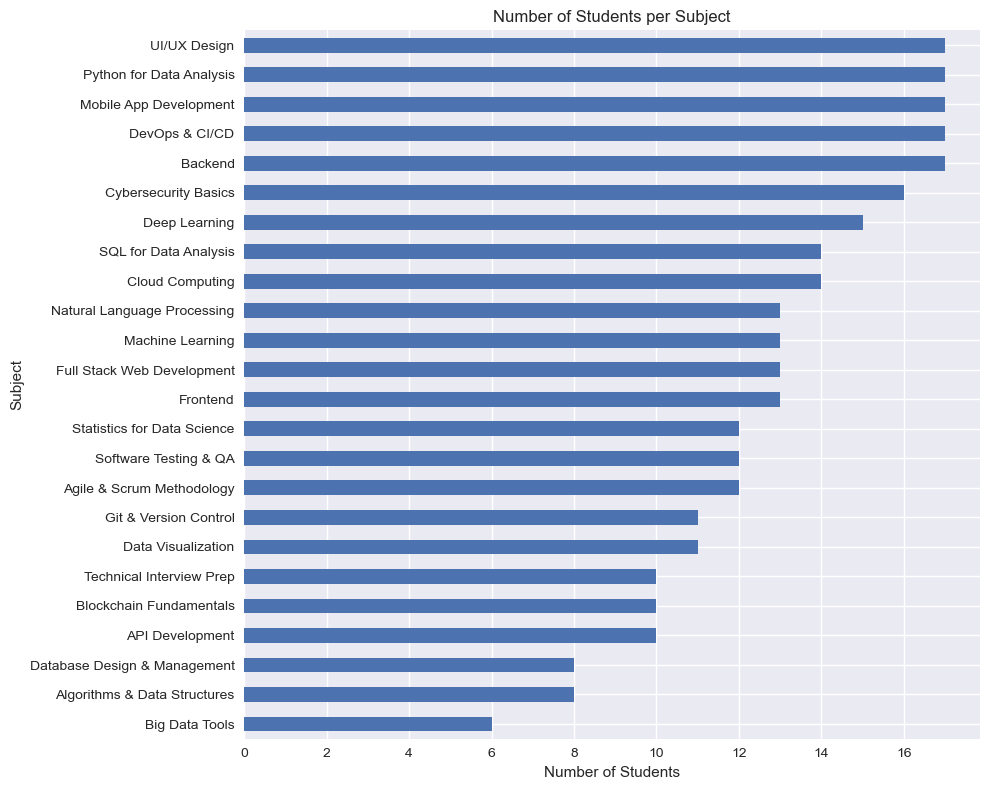

In [ ]:
query = """
SELECT
    s.subject_name,
    COUNT(DISTINCT ss.student_id) AS student_count
FROM
    student_subjects ss
JOIN
    subjects s ON ss.subject_id = s.subject_id
GROUP BY
    s.subject_name
ORDER BY
    student_count DESC;
"""

subject_df = pd.read_sql(query, conn)
print(subject_df.head())

subject_df.plot(
    kind='barh',
    x='subject_name',
    y='student_count',
    figsize=(10, 8),
    legend=False,
    title="Number of Students per Subject"
)
plt.xlabel("Number of Students")
plt.ylabel("Subject")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. Study Times

Knowing when students prefer to study supports scheduling synchronous sessions and nudges.


In [ ]:
query = """
SELECT
    s.subject_name,
    sd.day,
    COUNT(DISTINCT sd.student_id) AS student_count
FROM
    student_subjects ss
JOIN
    subjects s ON ss.subject_id = s.subject_id
JOIN
    study_days sd ON ss.student_id = sd.student_id
GROUP BY
    s.subject_name,
    sd.day
ORDER BY
    s.subject_name,
    sd.day;
"""

availability_df = pd.read_sql(query, conn)
print(availability_df.head())



      subject_name  day  student_count
0  API Development  Fri              6
1  API Development  Mon              7
2  API Development  Sat              6
3  API Development  Sun              5
4  API Development  Thu              5


In [ ]:
pivot = availability_df.pivot_table(
    index='subject_name',
    columns='day',
    values='student_count',
    fill_value=0
)

print(pivot.head())

day                            Fri   Mon  Sat  Sun  Thu  Tue  Wed
subject_name                                                     
API Development                6.0   7.0  6.0  5.0  5.0  3.0  3.0
Agile & Scrum Methodology      5.0  10.0  7.0  7.0  6.0  6.0  5.0
Algorithms & Data Structures   2.0   4.0  5.0  4.0  6.0  4.0  5.0
Backend                       11.0  10.0  8.0  5.0  9.0  9.0  7.0
Big Data Tools                 2.0   3.0  3.0  2.0  1.0  4.0  5.0


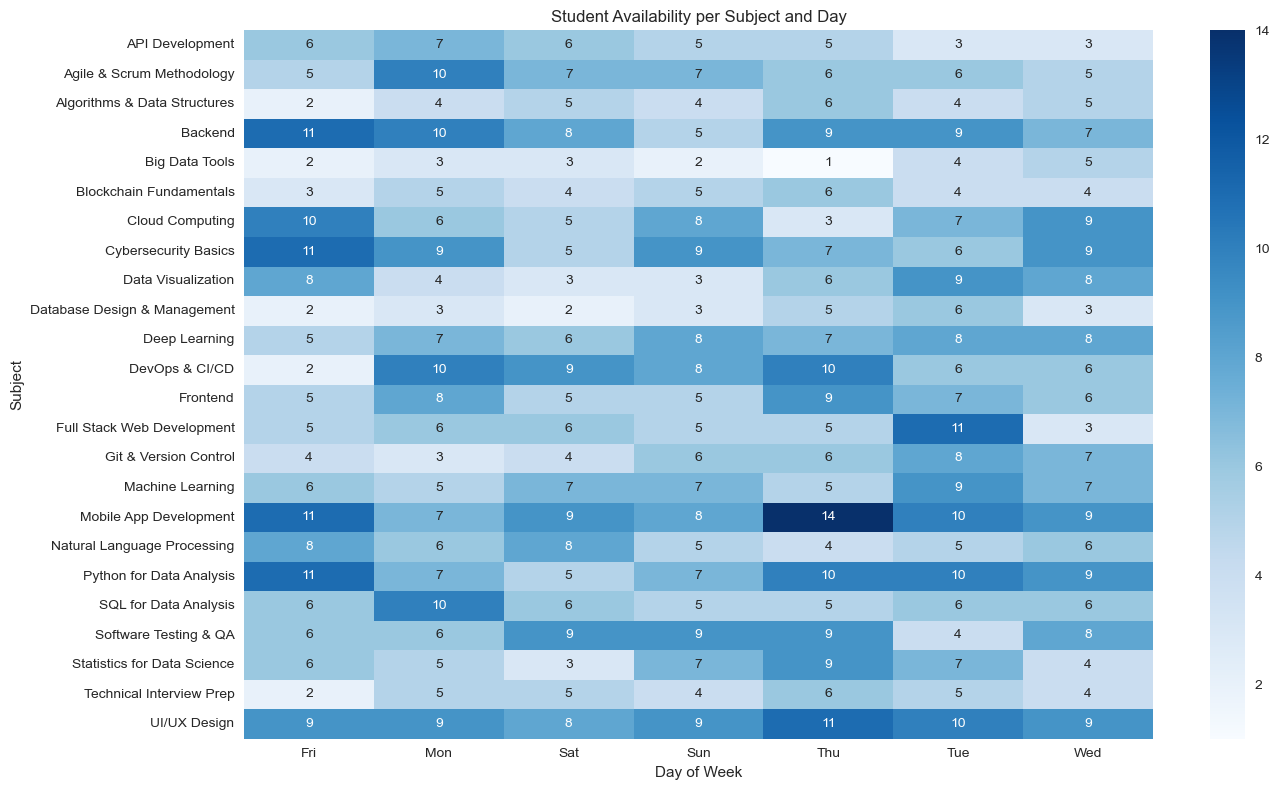

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap="Blues")
plt.title("Student Availability per Subject and Day")
plt.xlabel("Day of Week")
plt.ylabel("Subject")
plt.tight_layout()
plt.show()

In [ ]:
query = """
SELECT
    day
FROM
    study_days
"""

days_df = pd.read_sql(query, conn)
print(days_df.head())

   day
0  Wed
1  Thu
2  Sat
3  Sun
4  Mon


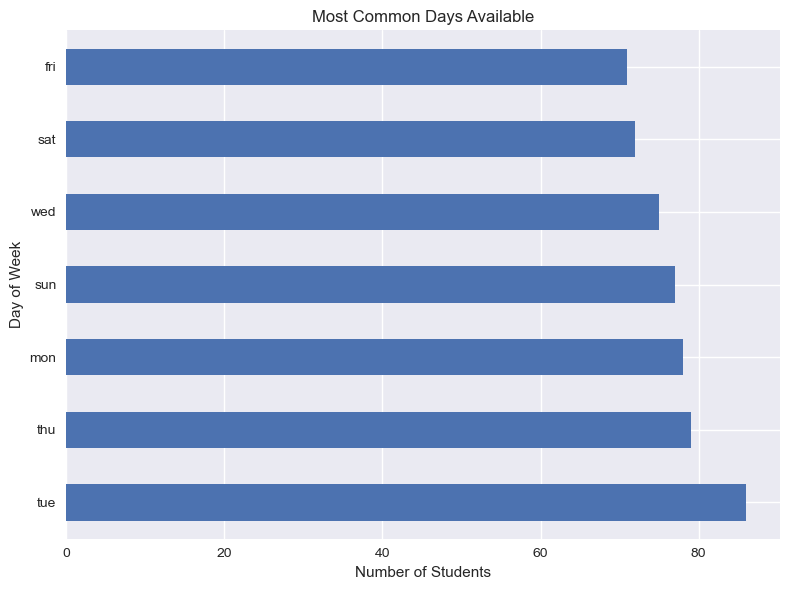

In [ ]:
day_series = days_df['day'].str.lower().str.replace(' ', '').str.split(',')
all_days = [day for sublist in day_series for day in sublist]
day_counts = pd.Series(all_days).value_counts()

day_counts.plot(kind='barh', title="Most Common Days Available", figsize=(8,6))
plt.xlabel("Number of Students")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


# 5. Personality Types & Study Styles

Understanding how personality types and study styles are distributed helps our app pair students who are likely to work well together, boosting study session effectiveness.



In [ ]:
query = """
SELECT
    personality_type,
    study_style
FROM
    students
"""

style_df = pd.read_sql(query, conn)

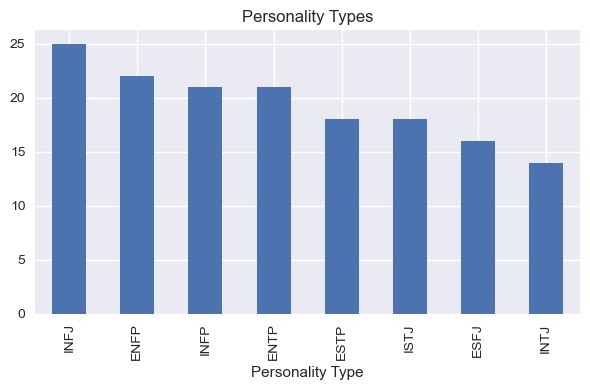

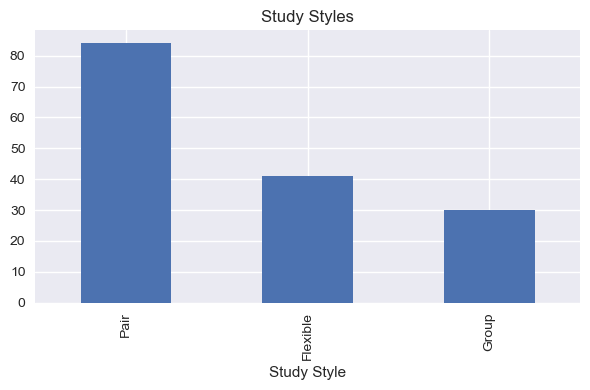

In [ ]:
style_df['personality_type'].value_counts().plot(kind='bar', title="Personality Types", figsize=(6,4))
plt.xlabel("Personality Type")
plt.tight_layout()
plt.show()

style_df['study_style'].value_counts().plot(kind='bar', title="Study Styles", figsize=(6,4))
plt.xlabel("Study Style")
plt.tight_layout()
plt.show()


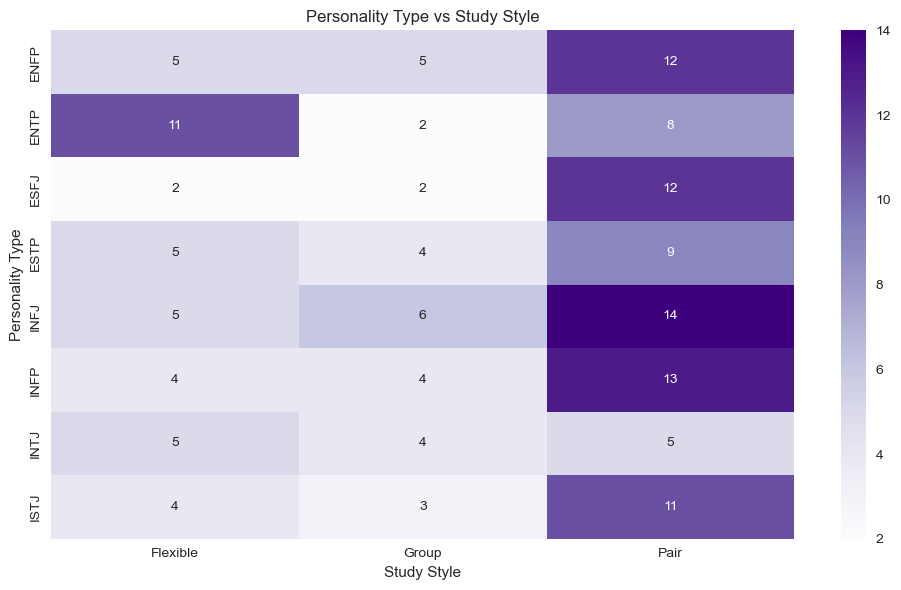

In [ ]:
ct = pd.crosstab(style_df['personality_type'], style_df['study_style'])

plt.figure(figsize=(10,6))
sns.heatmap(ct, annot=True, fmt='d', cmap="Purples")
plt.title("Personality Type vs Study Style")
plt.xlabel("Study Style")
plt.ylabel("Personality Type")
plt.tight_layout()
plt.show()


# 6. Experience Level vs GPA

We explore if self-reported experience levels align with academic performance, informing how we might pair students or suggest mentors.



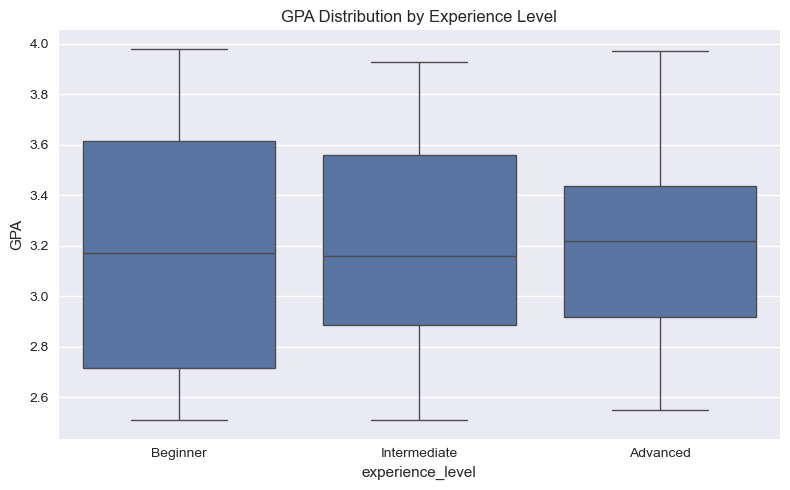

In [ ]:
query = """
SELECT
    experience_level,
    GPA
FROM
    students
WHERE
    GPA IS NOT NULL
"""

gpa_df = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))
sns.boxplot(data=gpa_df, x='experience_level', y='GPA')
plt.title("GPA Distribution by Experience Level")
plt.tight_layout()
plt.show()


# 7. Timezone Distribution

Knowing where students are located (via timezone) helps schedule live sessions or synchronous matching at compatible hours.



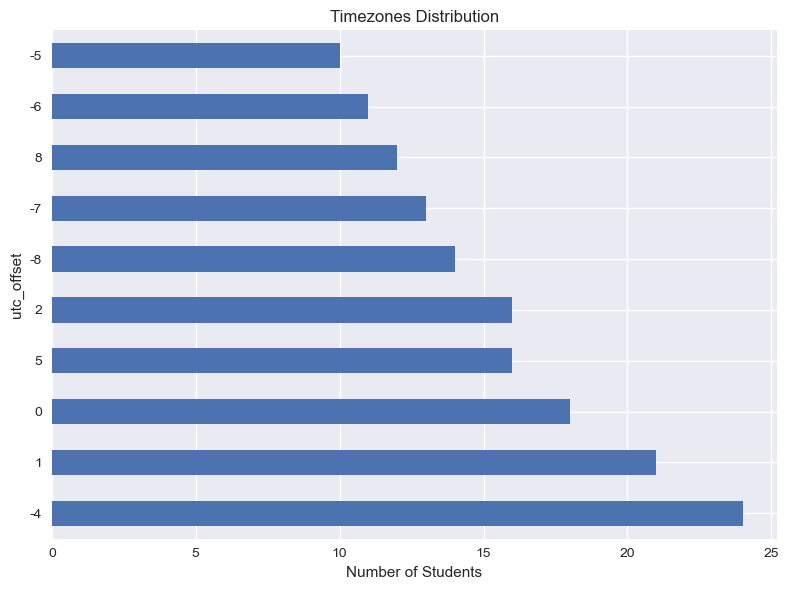

In [ ]:
query = """
SELECT
    utc_offset
FROM
    students
"""

tz_df = pd.read_sql(query, conn)

tz_df['utc_offset'].value_counts().plot(kind='barh', title="Timezones Distribution", figsize=(8,6))
plt.xlabel("Number of Students")
plt.tight_layout()
plt.show()


# Final EDA Summary

Our exploratory data analysis revealed key patterns in our student dataset that will directly inform the core features of the Virtual Study Buddy App:

- **Student Interests:** We identified the most popular subjects among students, highlighting areas where our matching engine should focus to maximize successful pairings.
  
- **Availability Patterns:** By analyzing study times and days of availability, we pinpointed peak periods when students are most likely to engage in study sessions or respond to notifications.

- **Personality Types & Study Styles:** We uncovered distributions of personality types and study styles, offering valuable insights to pair students with compatible or complementary learning approaches.

- **Experience & Academic Performance:** Examining experience levels alongside GPA helped us identify opportunities to match advanced students with those who could benefit from mentorship.

- **Student Availability per Subject:** Combining day and subject data allowed us to visualize when students interested in specific subjects are available, paving the way for smarter scheduling of group sessions or reminders.

This comprehensive EDA provides a strong foundation for building effective, data-driven matching algorithms, scheduling systems, and personalized engagement strategies.



In [ ]:
# Close database connection
conn.close()
